In [1]:
import os
import math
import sys

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from hydra import initialize, compose


# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):  # ../../
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.analysis import ft, stats
from mejiro.plots import plot

In [2]:
ps_dir = os.path.join(config.machine.data_dir, 'output', 'power_spectra')

# Set x-axis

NB this assumes both sets were generated 45 pixels on a side, 4.95 arcseconds

In [3]:
arcsec_min = 0.11
arcsec_max = 4.95

theta_list = ft.get_theta_list(arcsec_min, arcsec_max, 45)

# k_min = (2 * np.pi) / 4.95
# k_max = (2 * np.pi) / 0.11

# k_array = np.linspace(k_min, k_max, 45, endpoint=True)

# Poisson noise

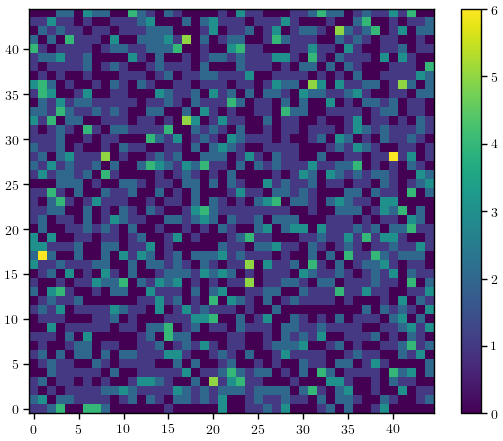

In [4]:
poisson_noise_file_list = glob(os.path.join(ps_dir, 'poisson_noise', 'poisson_noise_*.npy'))
poisson_noise_list = [np.load(file) for file in poisson_noise_file_list]

plt.imshow(poisson_noise_list[0])
plt.colorbar()
plt.show()

# Gaussian noise

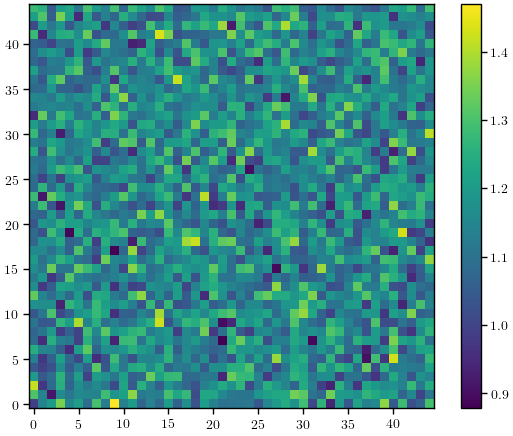

In [5]:
gaussian_noise_file_list = glob(os.path.join(ps_dir, 'gaussian_noise', 'gaussian_noise_*.npy'))
gaussian_noise_list = [np.load(file) for file in gaussian_noise_file_list]

plt.imshow(gaussian_noise_list[0])
plt.colorbar()
plt.show()

# Flat image

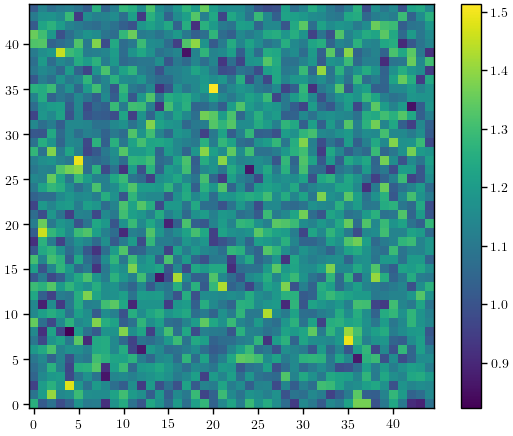

In [6]:
flat_images_file_list = glob(os.path.join(ps_dir, 'flat_images', 'flat_*.npy'))
flat_images_list = [np.load(file) for file in flat_images_file_list]

plt.imshow(flat_images_list[0])
plt.colorbar()
plt.show()

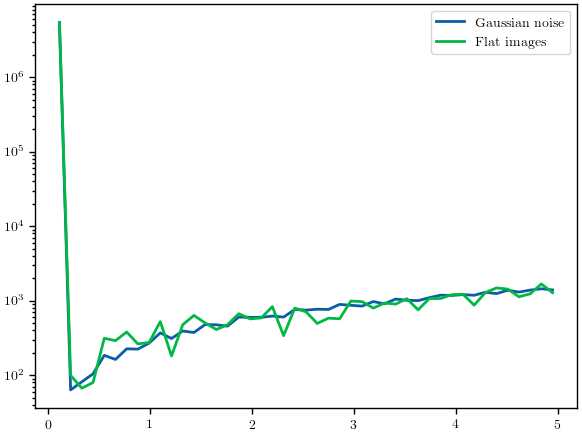

In [7]:
gaussian_noise_stack = np.vstack([ft.power_spectrum(i) for i in gaussian_noise_list])
flat_stack = np.vstack([ft.power_spectrum(i) for i in flat_images_list])

gaussian_noise_ps = np.mean(gaussian_noise_stack, axis=0)
flat_ps = np.mean(flat_stack, axis=0)

In [ ]:
plt.plot(theta_list, gaussian_noise_ps, label='Gaussian noise')
plt.plot(theta_list, flat_ps, label='Flat images')
plt.yscale('log')
plt.legend()
plt.show()

# Different PSFs

In [8]:
power_list_no_psf = [np.load(i) for i in glob(os.path.join(ps_dir, 'lenses', f'power_spectrum_lens_*_psf_none.npy'))]
power_list_gaussian_psf = [np.load(i) for i in glob(os.path.join(ps_dir, 'lenses',f'power_spectrum_lens_*_psf_gaussian.npy'))]
power_list_webbpsf = [np.load(i) for i in glob(os.path.join(ps_dir, 'lenses',f'power_spectrum_lens_*_psf_webbpsf.npy'))]

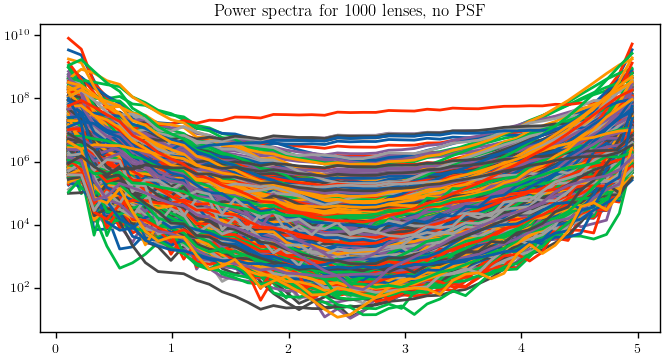

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
for power_spectrum in power_list_no_psf:
    ax.plot(theta_list, power_spectrum)

plt.yscale('log')
plt.title(f'Power spectra for {len(power_list_no_psf)} lenses, no PSF')
plt.show()

In [10]:
stack_list_no_psf = np.vstack(power_list_no_psf)
stack_list_gaussian_psf = np.vstack(power_list_gaussian_psf)
stack_list_webbpsf = np.vstack(power_list_webbpsf)

# Substructure

In [11]:
power_list_no_subhalos = [np.load(i) for i in glob(os.path.join(ps_dir, 'lenses',f'power_spectrum_lens_*_no_subhalos_image.npy'))]
power_list_cut_6 = [np.load(i) for i in glob(os.path.join(ps_dir, 'lenses',f'power_spectrum_lens_*_cut_6_image.npy'))]
power_list_cut_7 = [np.load(i) for i in glob(os.path.join(ps_dir, 'lenses',f'power_spectrum_lens_*_cut_7_image.npy'))]
power_list_cut_8 = [np.load(i) for i in glob(os.path.join(ps_dir, 'lenses',f'power_spectrum_lens_*_cut_8_image.npy'))]

power_list_no_subhalos_kappa = [np.load(i) for i in glob(os.path.join(ps_dir, 'lenses',f'power_spectrum_lens_*_no_subhalos_kappa.npy'))]
power_list_cut_6_kappa = [np.load(i) for i in glob(os.path.join(ps_dir, 'lenses',f'power_spectrum_lens_*_cut_6_kappa.npy'))]
power_list_cut_7_kappa = [np.load(i) for i in glob(os.path.join(ps_dir, 'lenses',f'power_spectrum_lens_*_cut_7_kappa.npy'))]
power_list_cut_8_kappa = [np.load(i) for i in glob(os.path.join(ps_dir, 'lenses',f'power_spectrum_lens_*_cut_8_kappa.npy'))]

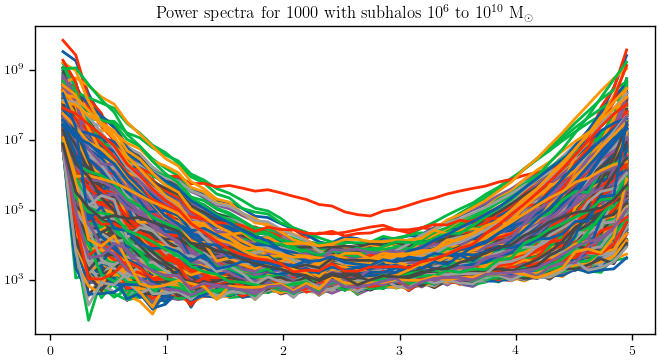

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))
for power_spectrum in power_list_cut_6:
    ax.plot(theta_list, power_spectrum)

plt.yscale('log')
plt.title(f'Power spectra for {len(power_list_cut_6)} with subhalos ' + r'$10^6$ to $10^{10}$ M$_\odot$')
plt.show()

In [13]:
stack_no_subhalos = np.vstack(power_list_no_subhalos)
stack_list_cut_6 = np.vstack(power_list_cut_6)
stack_list_cut_7 = np.vstack(power_list_cut_7)
stack_list_cut_8 = np.vstack(power_list_cut_8)

stack_no_subhalos_kappa = np.vstack(power_list_no_subhalos_kappa)
stack_list_cut_6_kappa = np.vstack(power_list_cut_6_kappa)
stack_list_cut_7_kappa = np.vstack(power_list_cut_7_kappa)
stack_list_cut_8_kappa = np.vstack(power_list_cut_8_kappa)

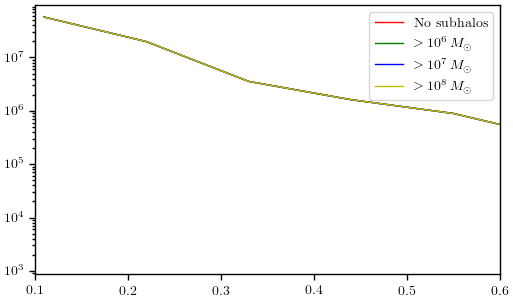

In [14]:
fig, ax = plt.subplots(figsize=(6, 3.5))
ax.plot(theta_list, np.mean(stack_no_subhalos, axis=0), color='r', label='No subhalos', linewidth=1.)
ax.plot(theta_list, np.mean(stack_list_cut_6, axis=0), color='g', label=r'$>10^6\,M_\odot$', linewidth=1.)
ax.plot(theta_list, np.mean(stack_list_cut_7, axis=0), color='b', label=r'$>10^7\,M_\odot$', linewidth=1.)
ax.plot(theta_list, np.mean(stack_list_cut_8, axis=0), color='y', label=r'$>10^8\,M_\odot$', linewidth=1.)
plt.legend()
plt.xlim(0.1, 0.6)
plt.yscale('log')
plt.show()

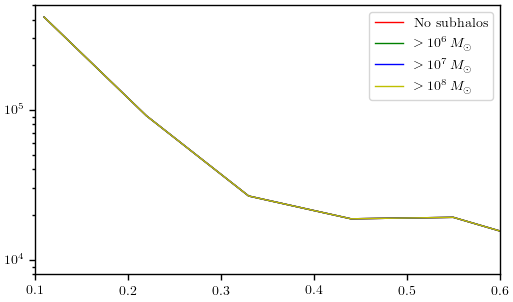

In [15]:
fig, ax = plt.subplots(figsize=(6, 3.5))
ax.plot(theta_list, np.mean(stack_no_subhalos_kappa, axis=0), color='r', label='No subhalos', linewidth=1.)
ax.plot(theta_list, np.mean(stack_list_cut_6_kappa, axis=0), color='g', label=r'$>10^6\,M_\odot$', linewidth=1.)
ax.plot(theta_list, np.mean(stack_list_cut_7_kappa, axis=0), color='b', label=r'$>10^7\,M_\odot$', linewidth=1.)
ax.plot(theta_list, np.mean(stack_list_cut_8_kappa, axis=0), color='y', label=r'$>10^8\,M_\odot$', linewidth=1.)
plt.legend()
plt.xlim(0.1, 0.6)
plt.yscale('log')
plt.show()

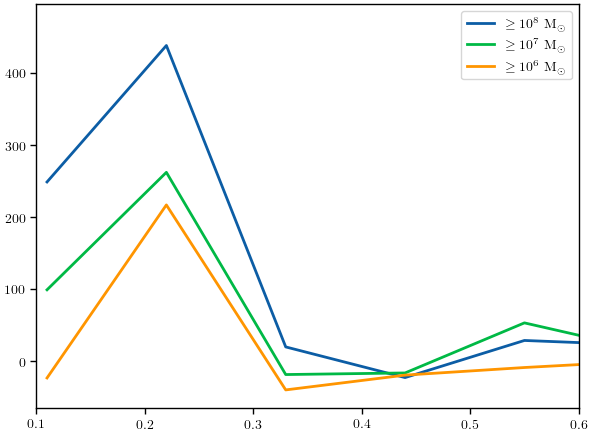

In [16]:
res_8 = np.mean(stack_list_cut_8, axis=0) - np.mean(stack_no_subhalos, axis=0)
res_7 = np.mean(stack_list_cut_7, axis=0) - np.mean(stack_no_subhalos, axis=0)
res_6 = np.mean(stack_list_cut_6, axis=0) - np.mean(stack_no_subhalos, axis=0)

plt.plot(theta_list, res_8, label='$\geq 10^8$ M$_\odot$')
plt.plot(theta_list, res_7, label='$\geq 10^7$ M$_\odot$')
plt.plot(theta_list, res_6, label='$\geq 10^6$ M$_\odot$')
plt.xlim(0.1, 0.6)
plt.legend()
plt.show()

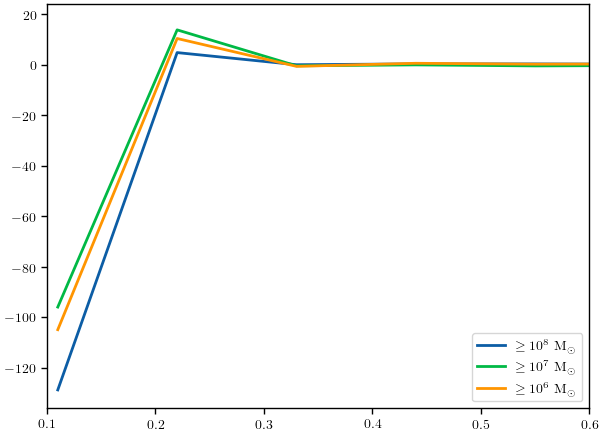

In [17]:
res_8_kappa = np.mean(stack_list_cut_8_kappa, axis=0) - np.mean(stack_no_subhalos_kappa, axis=0)
res_7_kappa = np.mean(stack_list_cut_7_kappa, axis=0) - np.mean(stack_no_subhalos_kappa, axis=0)
res_6_kappa = np.mean(stack_list_cut_6_kappa, axis=0) - np.mean(stack_no_subhalos_kappa, axis=0)

plt.plot(theta_list, res_8_kappa, label='$\geq 10^8$ M$_\odot$')
plt.plot(theta_list, res_7_kappa, label='$\geq 10^7$ M$_\odot$')
plt.plot(theta_list, res_6_kappa, label='$\geq 10^6$ M$_\odot$')
plt.xlim(0.1, 0.6)
plt.legend()
plt.show()

# Plot

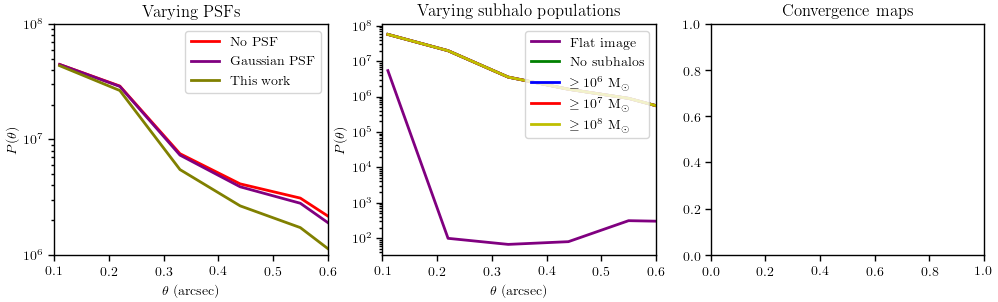

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

# remove vertical space between axes
# fig.subplots_adjust(hspace=0)

ax[0].plot(theta_list, np.mean(stack_list_no_psf, axis=0), label='No PSF', color='red')
ax[0].plot(theta_list, np.mean(stack_list_gaussian_psf, axis=0), label='Gaussian PSF', color='purple')
ax[0].plot(theta_list, np.mean(stack_list_webbpsf, axis=0), label='This work', color='olive')
# ax[0].axvline(0.151, label='PSF FWHM', color='c', linestyle='--')

# x1, x2, y1, y2 = 10, 40, 5 * 10 ** -5, 4 * 10 ** -3
# zoom_axes0 = ax[0].inset_axes(bounds=[0.05,0.05,0.5,0.5], xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
# zoom_axes0.loglog(k, power_no_psf, label='No PSF')
# zoom_axes0.loglog(k, power_gaussian_psf, label='Gaussian PSF')
# zoom_axes0.loglog(k, power_pandeia, label='WebbPSF')
# zoom_axes0.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
# ax[0].indicate_inset_zoom(zoom_axes0, edgecolor="black")

# ax[0].set_xscale('log')
ax[0].set_xlim(0.1, 0.6)
ax[0].set_ylim(1e6, 1e8)
ax[0].set_yscale('log')
ax[0].set_xlabel(r'$\theta$ (arcsec)')
ax[0].set_ylabel(r'$P(\theta)$')
ax[0].legend(loc='upper right')
ax[0].set_title('Varying PSFs')

ax[1].plot(theta_list, flat_ps, label='Flat image', color='purple')
ax[1].plot(theta_list, np.mean(stack_no_subhalos, axis=0), label='No subhalos', color='g')
ax[1].plot(theta_list, np.mean(stack_list_cut_6, axis=0), label='$\geq 10^6$ M$_\odot$', color='b')
ax[1].plot(theta_list, np.mean(stack_list_cut_7, axis=0), label='$\geq 10^7$ M$_\odot$', color='r')
ax[1].plot(theta_list, np.mean(stack_list_cut_8, axis=0), label='$\geq 10^8$ M$_\odot$', color='y')

# for power_spectrum in power_list_cut_6:
#     ax[1].plot(theta_list, power_spectrum, color='b', alpha=0.4, linewidth=0.2)

# n1, m1 = np.histogram(no_cut_masses, bins=np.logspace(6, 10, 10))
# n2, m2 = np.histogram(cut_7_masses, bins=np.logspace(6, 10, 11))
# n3, m3 = np.histogram(cut_8_masses, bins=np.logspace(6, 10, 11))

# inset_axes = ax[1].inset_axes(bounds=[0.65,0.65,0.25,0.3])
# inset_axes.loglog(m1[0:-1], n1)
# inset_axes.loglog(m2[0:-1], n2)
# inset_axes.loglog(m3[0:-1], n3)
# # inset_axes.set_ylim(-1, 0.1)
# inset_axes.set_xticks([10 ** 6, 10 ** 8, 10 ** 10])
# inset_axes.set_xlabel('Mass '+r'($M_{\odot}$)')
# inset_axes.set_ylabel('Count')

# x1, x2, y1, y2 = 0.1, 0.14, 1 * 10 ** 5, 1.25 * 10 ** 5
# zoom_axes = ax[1].inset_axes(bounds=[0.25,0.35,0.25,0.3], xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
# zoom_axes.plot(theta_array, np.flip(power_no_cut), label='No cut')
# zoom_axes.plot(theta_array, np.flip(power_cut_7), label='$\geq 10^7$ M$_\odot$')
# zoom_axes.plot(theta_array, np.flip(power_cut_8), label='$\geq 10^8$ M$_\odot$')
# zoom_axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
# ax[1].indicate_inset_zoom(zoom_axes, edgecolor="black")

# ax[1].set_xscale('log')
ax[1].set_xlim(0.1, 0.6)
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\theta$ (arcsec)')
# ax[1].set_xticks([10 ** 0, 10 ** 1])
ax[1].set_ylabel(r'$P(\theta)$')
ax[1].legend(loc='upper right')
ax[1].set_title(f'Varying subhalo populations')

ax[2].set_title(f'Convergence maps')


plt.savefig(os.path.join(figure_dir, 'power_spectra.png'))